In [1]:
import numpy as np
import copy
from data_preprocessing import preprocessing

In [2]:
# Dummy-Strafterm (z. B. 3 Punkte pro Dummy-Zuordnung)
DUMMY_PENALTY = 0
SEASON = "Season_6.json"

In [3]:
def enumerate_possible_matchings(probabilities, fixed, participants):
    """
    Enumeriert alle möglichen vollständigen Matchings (Matching Ceremonies), die konsistent mit den fixen Regeln sind:
      - Bestätigte Paare (fixed True, Wahrscheinlichkeit 1.0) sind fest vorgegeben.
      - Ausgeschlossene Paare (fixed True, Wahrscheinlichkeit 0.0) sind nicht erlaubt.
      - Für jeden übrigen Mann werden nur die erlaubten (nicht fixierten) Frauen in Betracht gezogen.
    
    Rückgabe:
      Eine Liste von Matchings. Jedes Matching ist ein Dictionary {man: woman}.
    """
    men = [m.lower() for m in participants['men']]
    women = [w.lower() for w in participants['women']]
    
    # Bestätigte Paare extrahieren und übrige Männer ermitteln
    confirmed = {}
    remaining_men = []
    allowed = {}
    
    for man in men:
        has_confirmed = False
        for woman in women:
            if fixed.get((man, woman), False) and probabilities.get((man, woman), 0) == 1.0:
                confirmed[man] = woman
                has_confirmed = True
                break
        if not has_confirmed:
            remaining_men.append(man)
            # Erlaubte Frauen: Nur jene, die nicht fixiert sind
            allowed[man] = [w for w in women if not fixed.get((man, w), False)]
    
    # Aus den erlaubten Listen werden bereits bestätigte Frauen entfernt
    for man in remaining_men:
        allowed[man] = [w for w in allowed[man] if w not in confirmed.values()]
    
    results = []
    
    def backtrack(i, current):
        if i == len(remaining_men):
            matching = confirmed.copy()
            matching.update(current)
            results.append(matching.copy())
            return
        man = remaining_men[i]
        for woman in allowed[man]:
            if woman in current.values() or woman in confirmed.values():
                continue
            current[man] = woman
            backtrack(i + 1, current)
            del current[man]
    
    backtrack(0, {})
    return results

In [4]:
def evaluate_matching(candidate, ceremonies):
    """
    Bewertet ein Kandidaten-Matching anhand der in den Ceremonies beobachteten Scores.
    Dummy-Zuordnungen werden zusätzlich stark bestraft.
    """
    total_cost = 0
    # Erzeuge die Menge der Paare im Kandidaten-Matching
    candidate_pairs = {(man, candidate[man]) for man in candidate}
    for ceremony in ceremonies:
        ceremony_pairs = {(p['man'].lower(), p['woman'].lower()) for p in ceremony['pairs']}
        observed_score = ceremony['score']
        # Zähle nur "echte" Übereinstimmungen (Dummy-Paare werden bestraft)
        matching_count = sum(
            1 for (man, woman) in candidate_pairs
            if not man.startswith("dummy") and not woman.startswith("dummy") and (man, woman) in ceremony_pairs
        )
        cost = abs(matching_count - observed_score)
        total_cost += cost

    # Zusätzlicher Strafterm: Für jede Dummy-Zuordnung im Matching
    for man, woman in candidate.items():
        if man.startswith("dummy") or woman.startswith("dummy"):
            total_cost += DUMMY_PENALTY
    return total_cost

In [5]:
def generate_neighbor(current_candidate, confirmed, variable_men, participants, fixed):
    """
    Erzeugt einen Nachbarn des aktuellen Kandidaten-Matchings.
    
    Es gibt drei Varianten:
      1. Einfacher Tausch zwischen zwei variablen Männern.
      2. Reassignment: Ein variabler Mann erhält eine alternative Zuordnung.
      3. Mehrfachtausch: Eine Gruppe von variablen Männern wird ausgewählt und deren Zuordnungen werden permutiert.
      
    Der Parameter 'op' entscheidet zufallsbasiert, welche Operation angewendet wird.
    """
    neighbor = copy.deepcopy(current_candidate)
    op = np.random.rand()
    
    if op < 0.4 and len(variable_men) >= 2:
        # Variante 1: Einfacher Tausch zwischen zwei variablen Männern
        m1, m2 = np.random.choice(variable_men, size=2, replace=False)
        neighbor[m1], neighbor[m2] = neighbor[m2], neighbor[m1]
        
    elif op < 0.7:
        # Variante 2: Reassignment: Ein variabler Mann erhält eine alternative Zuordnung
        m = np.random.choice(variable_men)
        # Erlaubte Frauen für m: alle Frauen, die nicht fixiert sind
        allowed_women = [w for w in participants['women'] if not fixed.get((m, w), False)]
        # Entferne bereits genutzte Frauen (bei variablen Männern) außer der aktuellen Zuordnung
        used_women = {neighbor[man] for man in variable_men if man != m}
        possible = [w for w in allowed_women if w not in used_women]
        if possible:
            neighbor[m] = np.random.choice(possible)
            
    else:
        # Variante 3: Mehrfachtausch (multiple swap)
        if len(variable_men) >= 2:
            # Wähle zufällig eine Gruppengröße k zwischen 2 und min(4, len(variable_men))
            k = np.random.randint(2, min(4, len(variable_men)) + 1)
            # Wähle k variable Männer zufällig aus
            chosen = np.random.choice(variable_men, size=k, replace=False)
            # Hole die aktuellen Zuordnungen dieser Männer
            current_assignments = [neighbor[m] for m in chosen]
            # Erzeuge eine zufällige Permutation dieser Zuordnungen
            perm = np.random.permutation(current_assignments)
            # Stelle sicher, dass die Permutation nicht identisch ist (falls ja, erneut versuchen)
            attempts = 0
            while all(a == b for a, b in zip(current_assignments, perm)) and attempts < 10:
                perm = np.random.permutation(current_assignments)
                attempts += 1
            # Übertrage die neue Zuordnung auf die ausgewählten Männer
            for i, m in enumerate(chosen):
                neighbor[m] = perm[i]
                
    return neighbor

In [6]:
def simulated_annealing_matching(initial_candidate, confirmed, variable_men, participants, fixed, ceremonies,
                                 initial_temp=100.0, cooling_rate=0.95, min_temp=0.1, max_iter=1000, reheating_steps=100):
    """
    Führt Simulated Annealing durch, um das Matching zu optimieren.
    - initial_candidate: Startlösung (Dictionary {man: woman})
    - confirmed: Dictionary der fixierten Paare
    - variable_men: Liste der Männer, die nicht fest zugeordnet sind
    - participants: Das ausgeglichene Teilnehmer-Dictionary
    - fixed: Dictionary mit fixen Paaren
    - ceremonies: Liste der Ceremonies (mit Scores und Paaren)
    
    Parameter:
      - initial_temp: Starttemperatur
      - cooling_rate: Abkühlrate (pro Iteration)
      - min_temp: Untere Grenze der Temperatur
      - max_iter: Maximale Iterationen
      - reheating_steps: Wenn über diese Anzahl von Schritten keine Verbesserung erfolgt, wird die Temperatur zurückgesetzt (Reheating)
    """
    current_candidate = copy.deepcopy(initial_candidate)
    current_cost = evaluate_matching(current_candidate, ceremonies)
    best_candidate = copy.deepcopy(current_candidate)
    best_cost = current_cost
    temp = initial_temp
    steps_since_improvement = 0

    for i in range(max_iter):
        neighbor = generate_neighbor(current_candidate, confirmed, variable_men, participants, fixed)
        neighbor_cost = evaluate_matching(neighbor, ceremonies)
        delta = neighbor_cost - current_cost

        # Akzeptiere Verbesserung oder verschlechterte Lösung mit Wahrscheinlichkeit exp(-delta/temp)
        if delta < 0 or np.random.rand() < np.exp(-delta / temp):
            current_candidate = neighbor
            current_cost = neighbor_cost
            steps_since_improvement = 0
            if current_cost < best_cost:
                best_candidate = copy.deepcopy(current_candidate)
                best_cost = current_cost
        else:
            steps_since_improvement += 1

        # Temperatur senken
        temp *= cooling_rate
        if temp < min_temp:
            # Reheating: Falls über eine gewisse Anzahl von Schritten keine Verbesserung, erhöh die Temperatur wieder
            if steps_since_improvement >= reheating_steps:
                temp = initial_temp
                steps_since_improvement = 0
            else:
                temp = min_temp

    return best_candidate, best_cost

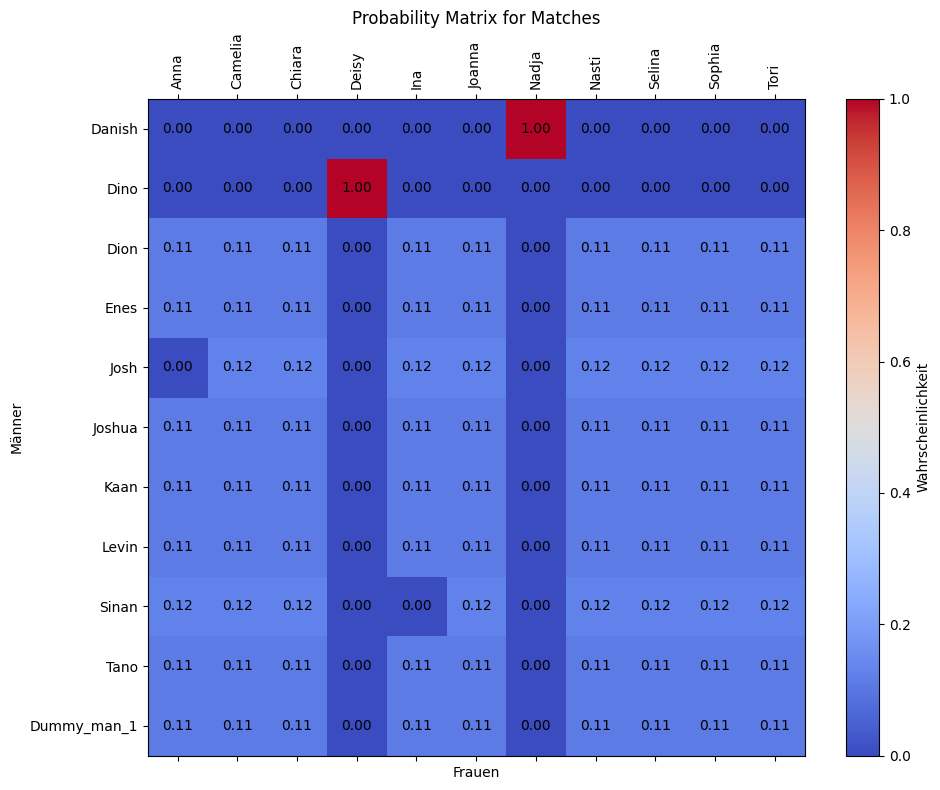


Häufigkeit der Paare (über alle Match Ceremonies):
Dino - Deisy: 6 mal
Tano - Tori: 5 mal
Levin - Camelia: 4 mal
Joshua - Joanna: 4 mal
Enes - Selina: 4 mal
Josh - Nadja: 3 mal
Kaan - Anna: 3 mal
Danish - Nadja: 3 mal
Sinan - Ina: 2 mal
Danish - Sophia: 2 mal
Levin - Chiara: 2 mal
Sinan - Nasti: 2 mal
Dion - Chiara: 2 mal
Josh - Ina: 2 mal
Kaan - Sophia: 2 mal
Kaan - Joanna: 1 mal
Dion - Tori: 1 mal
Enes - Anna: 1 mal
Joshua - Selina: 1 mal
Tano - Chiara: 1 mal
Dion - Selina: 1 mal
Enes - Nasti: 1 mal
Danish - Camelia: 1 mal
Sinan - Sophia: 1 mal
Dion - Nasti: 1 mal
Dion - Anna: 1 mal
Josh - Nasti: 1 mal
Sinan - Camelia: 1 mal
Joshua - Ina: 1 mal


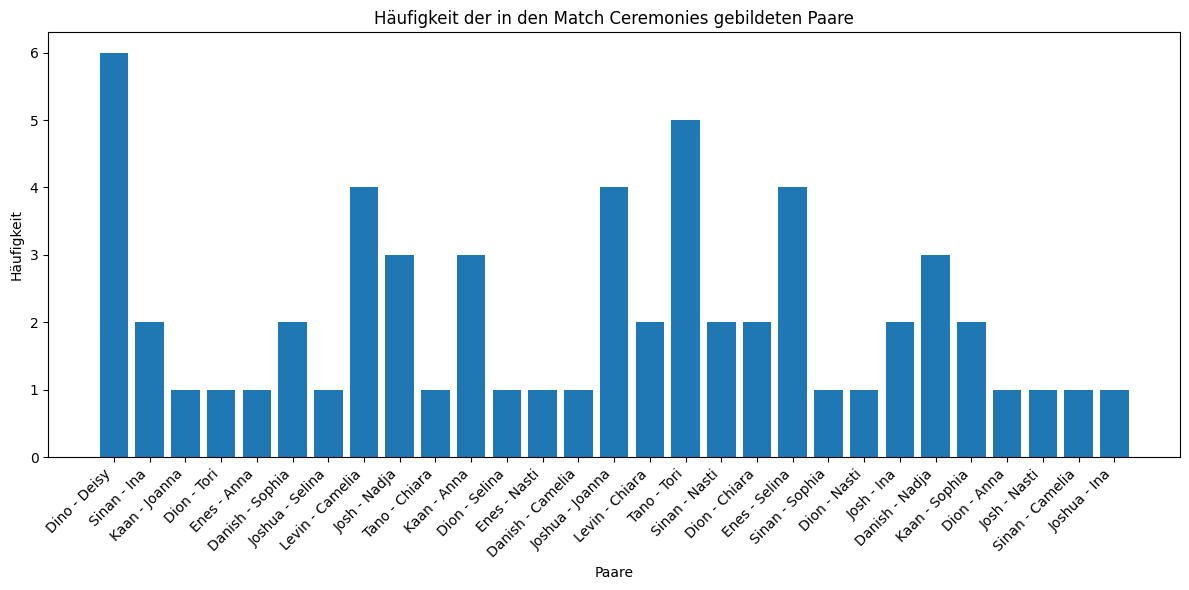

Anzahl möglicher vollständiger Matchings:  287280

Das beste durch Simulated Annealing gefundene Matching ist:
Danish - Nadja | Dino - Deisy | Dion - Camelia | Dummy_man_1 - Sophia | Enes - Tori | Josh - Anna | Joshua - Nasti | Kaan - Ina | Levin - Chiara | Sinan - Selina | Tano - Joanna | 
Gesamtkosten (Summe der Abweichungen + Dummy-Strafterm): 2


In [7]:
if __name__ == "__main__":
    season = SEASON
    # Preprocessing durchführen und Daten laden
    probabilities, fixed, participants, ceremonies = preprocessing(season)



    # Erzeuge den Suchraum (alle möglichen vollständigen Matchings)
    possible_matchings = enumerate_possible_matchings(probabilities, fixed, participants)

    # Anzahl der möglichen Matchings anzeigen
    print("Anzahl möglicher vollständiger Matchings: ", len(possible_matchings))


    # Erzeuge "confirmed" Dictionary: Fixe Zuordnungen, die nicht verändert werden sollen
    confirmed = {}
    for man in participants['men']:
        for woman in participants['women']:
            if fixed.get((man, woman), False) and probabilities.get((man, woman), 0) == 1.0:
                confirmed[man] = woman
                break

    # Variable Männer: diejenigen, die nicht in confirmed vorkommen
    variable_men = [man for man in participants['men'] if man not in confirmed]

    # Erzeuge ein initiales Matching:
    # Beginne mit den fixierten Paaren und ordne den restlichen Männern zufällig eine zulässige Frau zu.
    initial_candidate = confirmed.copy()
    used_women = set(confirmed.values())
    for man in variable_men:
        # Erlaube alle Frauen, die nicht fixiert sind
        allowed_women = [w for w in participants['women'] if not fixed.get((man, w), False) and w not in used_women]
        if not allowed_women:
            # Falls es keine freie Option gibt, wähle zufällig (kann z. B. einen Dummy beinhalten)
            allowed_women = [w for w in participants['women'] if not fixed.get((man, w), False)]
        chosen = np.random.choice(allowed_women)
        initial_candidate[man] = chosen
        used_women.add(chosen)

    # Führe Simulated Annealing aus:
    best_candidate, best_cost = simulated_annealing_matching(
        initial_candidate, confirmed, variable_men, participants, fixed, ceremonies,
        initial_temp=100.0, cooling_rate=0.95, min_temp=0.1, max_iter=100000, reheating_steps=10000
    )

    print("\nDas beste durch Simulated Annealing gefundene Matching ist:")
    for man, woman in sorted(best_candidate.items()):
        print(f"{man.capitalize()} - {woman.capitalize()}", end=" | ")
    print(f"\nGesamtkosten (Summe der Abweichungen + Dummy-Strafterm): {best_cost}")